# Cross-Modal Autoencoder for Image-Caption Retrieval

This notebook implements a cross-modal autoencoder where:
- Image latents decode into text feature space
- Text latents decode into image feature space

This forces the shared latent space to capture cross-modal information.

In [1]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import random

## 1. Load Pre-extracted Features

We'll use the features already extracted from the previous notebook:
- Image features: ResNet50 (2048-dim)
- Caption features: BERT (768-dim)

In [2]:
# Load the pre-split data
image_train = np.load("train_image_features.npy")
caption_train = np.load("train_caption_features.npy")
cap2img_train = np.load("train_caption_to_image.npy")

image_val = np.load("val_image_features.npy")
caption_val = np.load("val_caption_features.npy")
cap2img_val = np.load("val_caption_to_image.npy")

image_test = np.load("test_image_features.npy")
caption_test = np.load("test_caption_features.npy")
cap2img_test = np.load("test_caption_to_image.npy")

print("Train shapes:", image_train.shape, caption_train.shape, cap2img_train.shape)
print("Val shapes:", image_val.shape, caption_val.shape, cap2img_val.shape)
print("Test shapes:", image_test.shape, caption_test.shape, cap2img_test.shape)

Train shapes: (5663, 2048) (28315, 768) (28315,)
Val shapes: (1214, 2048) (6070, 768) (6070,)
Test shapes: (1214, 2048) (6070, 768) (6070,)


## 2. Normalize Features

Normalize using training set statistics

In [3]:
# Compute normalization parameters from training set
img_mean = image_train.mean(axis=0, keepdims=True)
img_std = image_train.std(axis=0, keepdims=True) + 1e-6

txt_mean = caption_train.mean(axis=0, keepdims=True)
txt_std = caption_train.std(axis=0, keepdims=True) + 1e-6

# Apply normalization
def normalize_images(x):
    return (x - img_mean) / img_std

def normalize_texts(x):
    return (x - txt_mean) / txt_std

image_train = normalize_images(image_train)
image_val = normalize_images(image_val)
image_test = normalize_images(image_test)

caption_train = normalize_texts(caption_train)
caption_val = normalize_texts(caption_val)
caption_test = normalize_texts(caption_test)

print("Normalization complete!")

Normalization complete!


## 3. Dataset and DataLoader

Pairs captions with their corresponding images

In [4]:
class CaptionImagePairedDataset(Dataset):
    """
    Iterates over captions. For index i, returns:
      caption_features[i], image_features[caption_to_image_idx[i]]
    """
    def __init__(self, caption_feats, image_feats, caption_to_image_idx):
        assert len(caption_feats) == len(caption_to_image_idx)
        self.caption_feats = caption_feats.astype(np.float32)
        self.image_feats = image_feats.astype(np.float32)
        self.cap2img = caption_to_image_idx.astype(np.int64)

    def __len__(self):
        return len(self.caption_feats)

    def __getitem__(self, idx):
        cap = self.caption_feats[idx]
        img = self.image_feats[self.cap2img[idx]]
        return {"image": torch.from_numpy(img), "caption": torch.from_numpy(cap)}

## 4. Configuration

In [5]:
config = {
    "latent_dim": 512,
    "img_input_dim": 2048,
    "txt_input_dim": 768,
    "img_encoder_hidden": 1024,
    "txt_encoder_hidden": 512,
    "batch_size": 128,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "epochs": 40,
    "lambda_recon": 1.0,      # Weight for cross-modal reconstruction
    "lambda_contrastive": 1.0,  # Weight for contrastive loss
    "temperature": 0.07,       # Temperature for contrastive loss
    "checkpoint_dir": "./cross_modal_checkpoints",
    "seed": 42,
}

# Set seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Create checkpoint directory
os.makedirs(config["checkpoint_dir"], exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 5. Cross-Modal Autoencoder Architecture

Key idea:
- Image encoder → latent → Text decoder (outputs text features)
- Text encoder → latent → Image decoder (outputs image features)

Both encoders output the same latent dimension, forcing shared representation.

In [6]:
class ImageEncoder(nn.Module):
    """Encodes images (2048-dim) to shared latent space (512-dim)"""
    def __init__(self, input_dim=2048, hidden_dim=1024, latent_dim=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)


class TextEncoder(nn.Module):
    """Encodes text (768-dim) to shared latent space (512-dim)"""
    def __init__(self, input_dim=768, hidden_dim=512, latent_dim=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)


class ImageDecoder(nn.Module):
    """Decodes from latent space (512-dim) to IMAGE features (2048-dim)"""
    def __init__(self, latent_dim=512, hidden_dim=1024, output_dim=2048):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.decoder(z)


class TextDecoder(nn.Module):
    """Decodes from latent space (512-dim) to TEXT features (768-dim)"""
    def __init__(self, latent_dim=512, hidden_dim=512, output_dim=768):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.decoder(z)


print("Model architecture defined!")

Model architecture defined!


## 6. Loss Functions

In [7]:
def contrastive_loss(z_img, z_txt, temperature=0.07):
    """
    Contrastive loss to align image and text embeddings.
    Encourages matching pairs to be close and non-matching pairs to be far.
    """
    # Normalize embeddings
    z_img_norm = F.normalize(z_img, dim=1)
    z_txt_norm = F.normalize(z_txt, dim=1)
    
    # Compute similarity matrix
    logits = torch.matmul(z_img_norm, z_txt_norm.T) / temperature
    
    # Labels: diagonal elements are positive pairs
    labels = torch.arange(z_img.size(0)).to(z_img.device)
    
    # Cross-entropy in both directions
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)
    
    return (loss_i2t + loss_t2i) / 2


# Reconstruction loss
recon_loss_fn = nn.MSELoss()

print("Loss functions defined!")

Loss functions defined!


## 7. Initialize Models and Optimizer

In [8]:
# Instantiate models
img_encoder = ImageEncoder(
    input_dim=config["img_input_dim"],
    hidden_dim=config["img_encoder_hidden"],
    latent_dim=config["latent_dim"]
).to(device)

txt_encoder = TextEncoder(
    input_dim=config["txt_input_dim"],
    hidden_dim=config["txt_encoder_hidden"],
    latent_dim=config["latent_dim"]
).to(device)

img_decoder = ImageDecoder(
    latent_dim=config["latent_dim"],
    hidden_dim=config["img_encoder_hidden"],
    output_dim=config["img_input_dim"]
).to(device)

txt_decoder = TextDecoder(
    latent_dim=config["latent_dim"],
    hidden_dim=config["txt_encoder_hidden"],
    output_dim=config["txt_input_dim"]
).to(device)

# Optimizer for all parameters
params = (
    list(img_encoder.parameters()) + 
    list(txt_encoder.parameters()) + 
    list(img_decoder.parameters()) + 
    list(txt_decoder.parameters())
)
optimizer = Adam(params, lr=config["lr"], weight_decay=config["weight_decay"])

print(f"Models initialized with {sum(p.numel() for p in params):,} total parameters")

Models initialized with 6,560,512 total parameters


## 8. Create DataLoaders

In [9]:
train_dataset = CaptionImagePairedDataset(caption_train, image_train, cap2img_train)
val_dataset = CaptionImagePairedDataset(caption_val, image_val, cap2img_val)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config["batch_size"], 
    shuffle=True, 
    num_workers=0
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["batch_size"], 
    shuffle=False, 
    num_workers=0
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 222, Val batches: 48


## 9. Training Loop

Cross-modal reconstruction:
- Image → img_encoder → z_img → txt_decoder → reconstructed text features
- Text → txt_encoder → z_txt → img_decoder → reconstructed image features

Plus contrastive loss to align z_img and z_txt

In [10]:
def run_epoch(loader, training=True):
    if training:
        img_encoder.train()
        txt_encoder.train()
        img_decoder.train()
        txt_decoder.train()
    else:
        img_encoder.eval()
        txt_encoder.eval()
        img_decoder.eval()
        txt_decoder.eval()

    total_recon_i2t = 0.0  # Image to text reconstruction
    total_recon_t2i = 0.0  # Text to image reconstruction
    total_contrast = 0.0   # Contrastive loss
    total_loss = 0.0
    n_samples = 0

    pbar = tqdm(loader, desc="train" if training else "val")
    with torch.set_grad_enabled(training):
        for batch in pbar:
            imgs = batch["image"].to(device)    # (B, 2048)
            caps = batch["caption"].to(device)  # (B, 768)
            batch_size = imgs.shape[0]

            # Forward pass: CROSS-MODAL reconstruction
            z_img = img_encoder(imgs)              # Image → latent
            z_txt = txt_encoder(caps)              # Text → latent
            
            txt_recon = txt_decoder(z_img)         # Image latent → text features
            img_recon = img_decoder(z_txt)         # Text latent → image features

            # Losses
            L_i2t = recon_loss_fn(txt_recon, caps)  # Image should reconstruct text
            L_t2i = recon_loss_fn(img_recon, imgs)  # Text should reconstruct image
            L_contrast = contrastive_loss(z_img, z_txt, temperature=config["temperature"])

            # Total loss
            loss = (
                config["lambda_recon"] * (L_i2t + L_t2i) + 
                config["lambda_contrastive"] * L_contrast
            )

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Accumulate metrics
            total_recon_i2t += L_i2t.item() * batch_size
            total_recon_t2i += L_t2i.item() * batch_size
            total_contrast += L_contrast.item() * batch_size
            total_loss += loss.item() * batch_size
            n_samples += batch_size

            pbar.set_postfix({
                "loss": f"{total_loss / n_samples:.4f}",
                "i2t": f"{total_recon_i2t / n_samples:.4f}",
                "t2i": f"{total_recon_t2i / n_samples:.4f}",
                "contrast": f"{total_contrast / n_samples:.4f}"
            })

    return {
        "loss": total_loss / n_samples,
        "L_i2t": total_recon_i2t / n_samples,
        "L_t2i": total_recon_t2i / n_samples,
        "L_contrast": total_contrast / n_samples
    }

## 10. Train the Model

In [11]:
best_val_loss = float("inf")

for epoch in range(1, config["epochs"] + 1):
    print(f"\n=== Epoch {epoch}/{config['epochs']} ===")
    train_metrics = run_epoch(train_loader, training=True)
    val_metrics = run_epoch(val_loader, training=False)

    print(f"Train loss: {train_metrics['loss']:.4f} | Val loss: {val_metrics['loss']:.4f}")

    # Save checkpoint every epoch
    ckpt = {
        "epoch": epoch,
        "img_encoder": img_encoder.state_dict(),
        "txt_encoder": txt_encoder.state_dict(),
        "img_decoder": img_decoder.state_dict(),
        "txt_decoder": txt_decoder.state_dict(),
        "optimizer": optimizer.state_dict(),
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "config": config
    }
    ckpt_path = os.path.join(config["checkpoint_dir"], f"cross_modal_epoch{epoch}.pt")
    torch.save(ckpt, ckpt_path)

    # Save best checkpoint
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        torch.save(ckpt, os.path.join(config["checkpoint_dir"], "cross_modal_best.pt"))
        print("Saved best checkpoint.")

print("Training finished!")


=== Epoch 1/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 275.19it/s, loss=4.6875, i2t=0.9280, t2i=0.8730, contrast=2.8865]


Train loss: 4.5266 | Val loss: 4.6875
Saved best checkpoint.

=== Epoch 2/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 276.79it/s, loss=4.5947, i2t=0.9206, t2i=0.8583, contrast=2.8159]


Train loss: 3.6663 | Val loss: 4.5947
Saved best checkpoint.

=== Epoch 3/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 265.67it/s, loss=4.6068, i2t=0.9207, t2i=0.8538, contrast=2.8324]


Train loss: 3.3092 | Val loss: 4.6068

=== Epoch 4/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 246.12it/s, loss=4.6124, i2t=0.9220, t2i=0.8501, contrast=2.8403]


Train loss: 3.0773 | Val loss: 4.6124

=== Epoch 5/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 242.90it/s, loss=4.6200, i2t=0.9240, t2i=0.8475, contrast=2.8485]


Train loss: 2.8974 | Val loss: 4.6200

=== Epoch 6/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 217.19it/s, loss=4.5969, i2t=0.9201, t2i=0.8446, contrast=2.8323]


Train loss: 2.7855 | Val loss: 4.5969

=== Epoch 7/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 248.28it/s, loss=4.5892, i2t=0.9211, t2i=0.8441, contrast=2.8241]


Train loss: 2.6919 | Val loss: 4.5892
Saved best checkpoint.

=== Epoch 8/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 273.01it/s, loss=4.5969, i2t=0.9224, t2i=0.8419, contrast=2.8326]


Train loss: 2.6133 | Val loss: 4.5969

=== Epoch 9/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 247.38it/s, loss=4.5778, i2t=0.9209, t2i=0.8418, contrast=2.8152]


Train loss: 2.5449 | Val loss: 4.5778
Saved best checkpoint.

=== Epoch 10/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 258.62it/s, loss=4.5927, i2t=0.9228, t2i=0.8412, contrast=2.8288]


Train loss: 2.4922 | Val loss: 4.5927

=== Epoch 11/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 243.28it/s, loss=4.6037, i2t=0.9247, t2i=0.8397, contrast=2.8393]


Train loss: 2.4500 | Val loss: 4.6037

=== Epoch 12/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 252.14it/s, loss=4.6079, i2t=0.9231, t2i=0.8416, contrast=2.8431]


Train loss: 2.4126 | Val loss: 4.6079

=== Epoch 13/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 282.97it/s, loss=4.5985, i2t=0.9295, t2i=0.8397, contrast=2.8293]


Train loss: 2.3786 | Val loss: 4.5985

=== Epoch 14/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 257.52it/s, loss=4.6004, i2t=0.9271, t2i=0.8417, contrast=2.8316]


Train loss: 2.3455 | Val loss: 4.6004

=== Epoch 15/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 274.42it/s, loss=4.6045, i2t=0.9232, t2i=0.8425, contrast=2.8387]


Train loss: 2.3175 | Val loss: 4.6045

=== Epoch 16/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 255.78it/s, loss=4.6061, i2t=0.9247, t2i=0.8420, contrast=2.8395]


Train loss: 2.2809 | Val loss: 4.6061

=== Epoch 17/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 244.78it/s, loss=4.5932, i2t=0.9233, t2i=0.8388, contrast=2.8312]


Train loss: 2.2765 | Val loss: 4.5932

=== Epoch 18/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 274.67it/s, loss=4.5920, i2t=0.9256, t2i=0.8371, contrast=2.8293]


Train loss: 2.2528 | Val loss: 4.5920

=== Epoch 19/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 267.76it/s, loss=4.5936, i2t=0.9282, t2i=0.8390, contrast=2.8264]


Train loss: 2.2318 | Val loss: 4.5936

=== Epoch 20/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 270.61it/s, loss=4.6011, i2t=0.9263, t2i=0.8384, contrast=2.8363]


Train loss: 2.2103 | Val loss: 4.6011

=== Epoch 21/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 258.15it/s, loss=4.6162, i2t=0.9255, t2i=0.8430, contrast=2.8477]


Train loss: 2.1871 | Val loss: 4.6162

=== Epoch 22/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 280.60it/s, loss=4.6131, i2t=0.9264, t2i=0.8402, contrast=2.8465]


Train loss: 2.1772 | Val loss: 4.6131

=== Epoch 23/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 278.72it/s, loss=4.6137, i2t=0.9255, t2i=0.8449, contrast=2.8433]


Train loss: 2.1644 | Val loss: 4.6137

=== Epoch 24/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 260.97it/s, loss=4.6368, i2t=0.9279, t2i=0.8460, contrast=2.8629]


Train loss: 2.1515 | Val loss: 4.6368

=== Epoch 25/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 229.44it/s, loss=4.6244, i2t=0.9280, t2i=0.8397, contrast=2.8567]


Train loss: 2.1404 | Val loss: 4.6244

=== Epoch 26/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 279.06it/s, loss=4.6200, i2t=0.9276, t2i=0.8408, contrast=2.8516]


Train loss: 2.1185 | Val loss: 4.6200

=== Epoch 27/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 269.04it/s, loss=4.5996, i2t=0.9254, t2i=0.8373, contrast=2.8369]


Train loss: 2.1074 | Val loss: 4.5996

=== Epoch 28/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 250.06it/s, loss=4.6189, i2t=0.9253, t2i=0.8410, contrast=2.8526]


Train loss: 2.1045 | Val loss: 4.6189

=== Epoch 29/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 263.44it/s, loss=4.6231, i2t=0.9294, t2i=0.8387, contrast=2.8550]


Train loss: 2.0972 | Val loss: 4.6231

=== Epoch 30/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 272.92it/s, loss=4.6089, i2t=0.9253, t2i=0.8399, contrast=2.8436]


Train loss: 2.0795 | Val loss: 4.6089

=== Epoch 31/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 235.70it/s, loss=4.6212, i2t=0.9250, t2i=0.8406, contrast=2.8556]


Train loss: 2.0671 | Val loss: 4.6212

=== Epoch 32/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 278.08it/s, loss=4.6209, i2t=0.9281, t2i=0.8394, contrast=2.8534]


Train loss: 2.0607 | Val loss: 4.6209

=== Epoch 33/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 258.26it/s, loss=4.6221, i2t=0.9269, t2i=0.8402, contrast=2.8550]


Train loss: 2.0517 | Val loss: 4.6221

=== Epoch 34/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 247.35it/s, loss=4.6195, i2t=0.9305, t2i=0.8409, contrast=2.8482]


Train loss: 2.0442 | Val loss: 4.6195

=== Epoch 35/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 252.20it/s, loss=4.6275, i2t=0.9273, t2i=0.8407, contrast=2.8596]


Train loss: 2.0295 | Val loss: 4.6275

=== Epoch 36/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 274.47it/s, loss=4.6352, i2t=0.9279, t2i=0.8427, contrast=2.8646]


Train loss: 2.0242 | Val loss: 4.6352

=== Epoch 37/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 272.12it/s, loss=4.6101, i2t=0.9276, t2i=0.8390, contrast=2.8434]


Train loss: 2.0160 | Val loss: 4.6101

=== Epoch 38/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 252.62it/s, loss=4.6196, i2t=0.9243, t2i=0.8393, contrast=2.8559]


Train loss: 2.0140 | Val loss: 4.6196

=== Epoch 39/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 269.36it/s, loss=4.6259, i2t=0.9286, t2i=0.8442, contrast=2.8531]


Train loss: 2.0039 | Val loss: 4.6259

=== Epoch 40/40 ===


val: 100%|██████████| 48/48 [00:00<00:00, 235.19it/s, loss=4.6347, i2t=0.9274, t2i=0.8405, contrast=2.8668]


Train loss: 1.9966 | Val loss: 4.6347
Training finished!


## 11. Evaluation: Load Best Model and Compute Retrieval Metrics

In [12]:
# Load best checkpoint
best_ckpt_path = os.path.join(config["checkpoint_dir"], "cross_modal_best.pt")
ckpt = torch.load(best_ckpt_path, map_location=device)

img_encoder.load_state_dict(ckpt["img_encoder"])
txt_encoder.load_state_dict(ckpt["txt_encoder"])
img_encoder.eval()
txt_encoder.eval()

print(f"Loaded best checkpoint from epoch {ckpt['epoch']}")

Loaded best checkpoint from epoch 9


In [13]:
def encode_features(image_feats, caption_feats):
    """
    Encode images and captions into latent space.
    """
    with torch.no_grad():
        # Encode images
        Z_imgs = []
        for i in range(0, image_feats.shape[0], 256):
            batch = torch.from_numpy(image_feats[i:i+256]).float().to(device)
            z = img_encoder(batch)
            Z_imgs.append(z.cpu().numpy())
        Z_imgs = np.concatenate(Z_imgs, axis=0)

        # Encode captions
        Z_caps = []
        for i in range(0, caption_feats.shape[0], 256):
            batch = torch.from_numpy(caption_feats[i:i+256]).float().to(device)
            z = txt_encoder(batch)
            Z_caps.append(z.cpu().numpy())
        Z_caps = np.concatenate(Z_caps, axis=0)

    return Z_imgs, Z_caps

In [14]:
def retrieval_metrics(Z_caps, Z_imgs, caption_to_image_idx):
    """
    Compute Recall@K metrics for image retrieval given captions.
    """
    sims = cosine_similarity(Z_caps, Z_imgs)  # (num_caps, num_imgs)
    ranks = []
    for i, true_img_idx in enumerate(caption_to_image_idx):
        sim_scores = sims[i]
        sorted_indices = np.argsort(-sim_scores)  # descending
        rank = np.where(sorted_indices == true_img_idx)[0][0] + 1
        ranks.append(rank)

    ranks = np.array(ranks)
    recall_at_1 = np.mean(ranks <= 1)
    recall_at_5 = np.mean(ranks <= 5)
    recall_at_10 = np.mean(ranks <= 10)
    med_rank = np.median(ranks)

    return {
        "Recall@1": recall_at_1,
        "Recall@5": recall_at_5,
        "Recall@10": recall_at_10,
        "MedianRank": med_rank
    }

### Validation Set Metrics

In [15]:
print("Encoding validation set...")
Z_imgs_val, Z_caps_val = encode_features(image_val, caption_val)
print(f"Encoded shapes: {Z_imgs_val.shape}, {Z_caps_val.shape}")

metrics_val = retrieval_metrics(Z_caps_val, Z_imgs_val, cap2img_val)
print("\nValidation Set Metrics:")
for k, v in metrics_val.items():
    print(f"  {k}: {v:.4f}")

Encoding validation set...
Encoded shapes: (1214, 512), (6070, 512)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



Validation Set Metrics:
  Recall@1: 0.1250
  Recall@5: 0.3517
  Recall@10: 0.4895
  MedianRank: 11.0000


### Test Set Metrics

In [16]:
print("Encoding test set...")
Z_imgs_test, Z_caps_test = encode_features(image_test, caption_test)
print(f"Encoded shapes: {Z_imgs_test.shape}, {Z_caps_test.shape}")

metrics_test = retrieval_metrics(Z_caps_test, Z_imgs_test, cap2img_test)
print("\nTest Set Metrics:")
for k, v in metrics_test.items():
    print(f"  {k}: {v:.4f}")

Encoding test set...
Encoded shapes: (1214, 512), (6070, 512)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



Test Set Metrics:
  Recall@1: 0.1306
  Recall@5: 0.3567
  Recall@10: 0.4926
  MedianRank: 11.0000


## 12. Visualization (Optional)

Visualize some retrieval results

In [17]:
# Load additional data for visualization
import pandas as pd

# Load original dataframe and metadata
df = pd.read_csv('/Users/sabrinafowler/Deep-Learning-Divas/archive/captions.txt')
image_names = np.load('flickr8k_image_names.npy')

# Load split indices to get validation masks
from sklearn.model_selection import train_test_split
n_images = len(image_names)
indices = np.arange(n_images)
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=42, shuffle=True)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)

# Create masks
caption_to_image_idx = df["image"].map({name: i for i, name in enumerate(image_names)}).values.astype(int)
val_mask = np.isin(caption_to_image_idx, val_idx)

# Get validation caption texts and image names
val_caption_texts = df["caption"].values[val_mask]
val_image_names = np.array([image_names[i] for i in val_idx])

print(f"Loaded {len(val_caption_texts)} validation captions")

Loaded 6070 validation captions



=== Retrieval Examples ===

CAPTION: A male jumps in the air while on a skateboard .
TRUE IMAGE: 3677954655_df4c0845aa.jpg (index 581)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


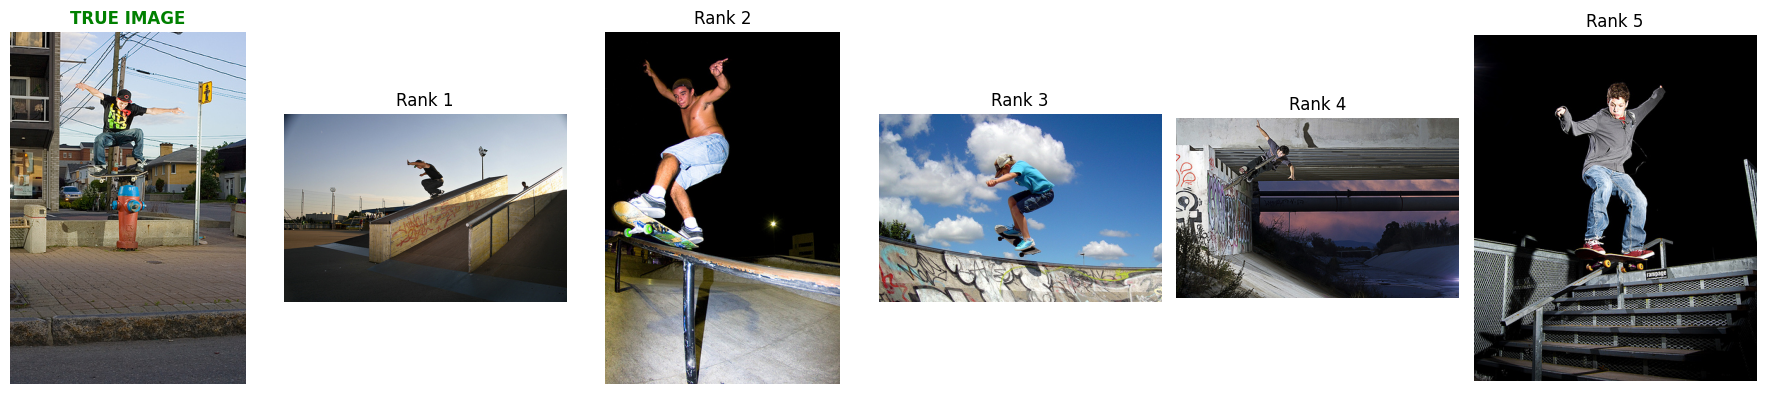


CAPTION: A dog wrapped with straps is walking away from a red tray holding a bag .
TRUE IMAGE: 3247693965_845b3b4349.jpg (index 978)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


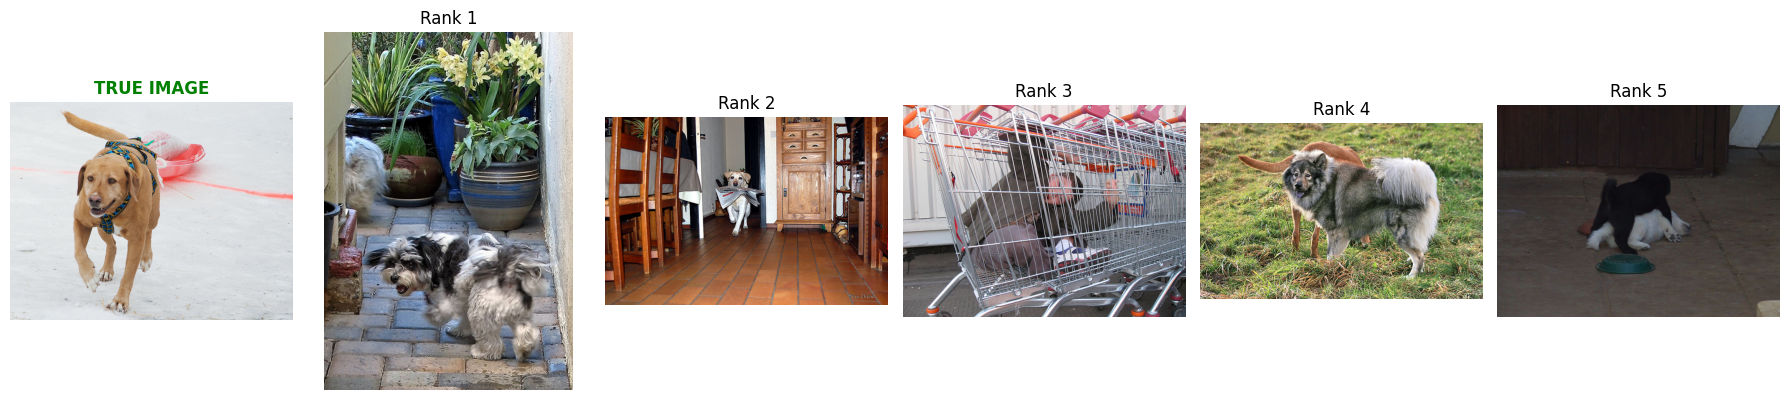

/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



CAPTION: A couple walk to the side of a crowded walkway .
TRUE IMAGE: 3286822339_5535af6b93.jpg (index 880)


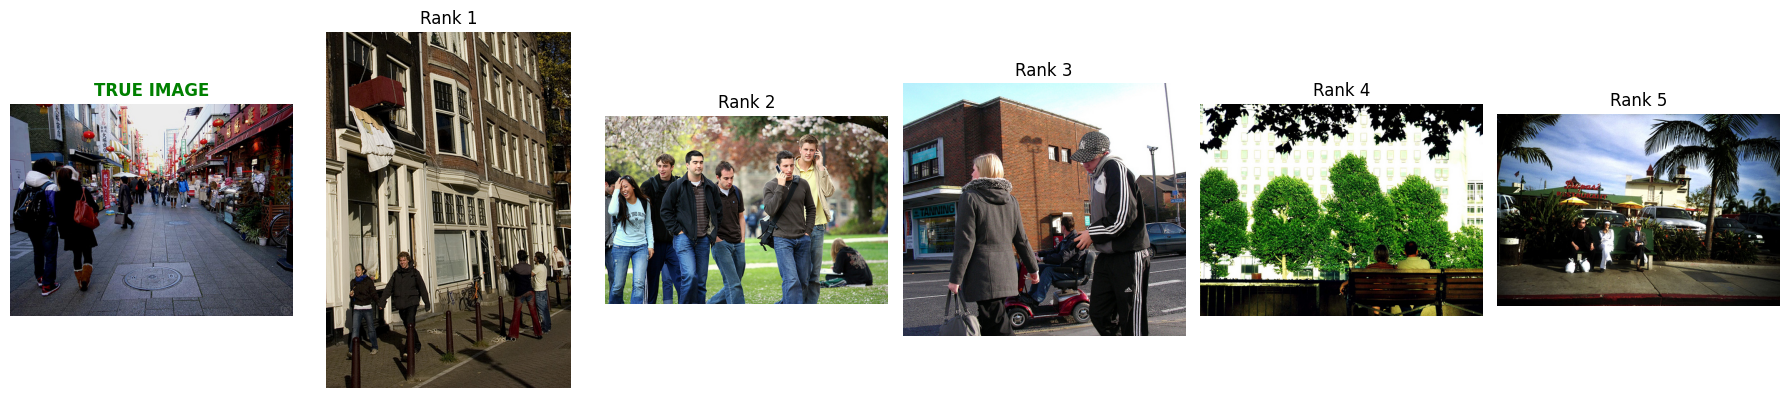

In [18]:
image_dir = "/Users/sabrinafowler/Deep-Learning-Divas/archive/Images"

def show_top_images_for_caption(caption_idx, top_k=5):
    """
    Show top-k retrieved validation images for a given caption index.
    """
    caption_embedding = Z_caps_val[caption_idx].reshape(1, -1)
    sims = cosine_similarity(caption_embedding, Z_imgs_val)[0]
    top_img_indices = np.argsort(-sims)[:top_k]

    print(f"\nCAPTION: {val_caption_texts[caption_idx]}")
    true_img_idx = cap2img_val[caption_idx]
    print(f"TRUE IMAGE: {val_image_names[true_img_idx]} (index {true_img_idx})")
    
    plt.figure(figsize=(18, 4))
    
    # Show true image
    true_img_name = val_image_names[true_img_idx]
    true_img_path = os.path.join(image_dir, true_img_name)
    try:
        true_img = Image.open(true_img_path)
        plt.subplot(1, top_k + 1, 1)
        plt.imshow(true_img)
        plt.axis('off')
        plt.title("TRUE IMAGE", fontweight='bold', color='green')
    except Exception as e:
        print(f"Could not open true image: {e}")
    
    # Show retrieved images
    for i, img_idx in enumerate(top_img_indices):
        img_name = val_image_names[img_idx]
        img_path = os.path.join(image_dir, img_name)
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Could not open {img_path}: {e}")
            continue
        
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')
        
        if img_idx == true_img_idx:
            plt.title(f"Rank {i+1} ✓", fontweight='bold', color='green')
        else:
            plt.title(f"Rank {i+1}")
    
    plt.tight_layout()
    plt.show()

# Show some random examples
print("\n=== Retrieval Examples ===")
for i in random.sample(range(len(Z_caps_val)), 3):
    show_top_images_for_caption(i, top_k=5)